# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Customer Segmentation</p>

This project, performs unsupervised clustering of data on the "Installs_and downloads" records from Terragon's database. with the aim of separating customers into groups that reflect similarities among customers in each cluster. The population is divided into segments to potentially maximize marketing oppuunities as well as modify products according to distinct needs and behaviours of the customers.


   <a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">TABLE OF CONTENTS</p>   
    
* [1. IMPORTING LIBRARIES](#1)
    
* [2. LOADING DATA](#2)
    
* [3. DATA CLEANING](#3)
    
* [4. DATA PREPROCESSING](#4)   
    
* [5. DIMENSIONALITY REDUCTION](#5) 
      
* [6. CLUSTERING](#6)
    
* [7. EVALUATING MODELS](#7)
    
* [8. PROFILING-FUTUTRE WORK](#8)
    
* [9. CONCLUSION](#9)
    



<a id="1"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">IMPORTING LIBRARIES</p>

In [ ]:
#Importing the Libraries
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

<a id="2"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">LOADING DATA</p>

In [2]:
#Loading the dataset
data = pd.read_csv("Installs and Download - Installs and Download.csv",parse_dates=['timestamp'])
print("Number of datapoints:", len(data))
data.head(1)

Number of datapoints: 27564


,msisdn,timeline,timestamp,event_type,ad_text,spend_total,spend_vas,sms_cost,spend_voice,spend_data,...,gender,has_bank,location_region,location_state,location_lga,device_manufacturer,device_model,device_type,os_vendor,os_name
0,af81bb96f9ccd7ecc223495ba44efc70,1.561736e+12,2019-07-07 07:59:40+00:00,install,All your favorite songs in just one place! Dow...,7366.4,0.0,0.0,0.0,0.0,...,M,No,north east,borno,maiduguri,samsung,galaxy a30 (sma305f,Smartphone,ds),google


**About the dataset:** 
The dataset consists of 27564 datapoints and 23 attributes
It can be categorized into into the following subsets

Customer information: msisdn,timeline,timestamp, customer_value
		      age,gender,has_bank,location_region
                      location_state,location_lga

Channel: device_manufacturer,device_model,device_type
	 os_vendor,os_name

Products: spend_total,spend_vas,sms_cost,spend_voice,
	  spend_data

<a id="3"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">DATA CLEANING</p>

**In this section** 
* Data Cleaning
* Feature Engineering 
 
Let us have a look at the information in data. 


In [3]:
#Information on features 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27564 entries, 0 to 27563
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   msisdn               27564 non-null  object 
 1   timeline             13513 non-null  float64
 2   timestamp            27561 non-null  object 
 3   event_type           27564 non-null  object 
 4   ad_text              27480 non-null  object 
 5   spend_total          27425 non-null  float64
 6   spend_vas            23880 non-null  float64
 7   sms_cost             23880 non-null  float64
 8   spend_voice          23880 non-null  float64
 9   spend_data           23880 non-null  float64
 10  customer_class       27425 non-null  float64
 11  customer_value       27425 non-null  object 
 12  age                  27483 non-null  float64
 13  gender               27287 non-null  object 
 14  has_bank             27540 non-null  object 
 15  location_region      25766 non-null 

**From the above output, we can conclude and note that:**

* There are missing values in all fields except 'msiddn' and 'event_type'
* timestamp that indicates the date a customer joined the database is not parsed as DateTime
* There are some categorical features in our data frame; as there are some features in dtype: object). So we will need to encode them into numeric forms later. 

For the missing values,dropping the rows that have missing spend_total. 

In [4]:
#To remove the NA values
missing_index = data[data['spend_total'].isnull()].index.tolist()
data.drop(missing_index,inplace = True)
#data = data['spend_total'].dropna()

print("The total number of data-points after removing the rows with missing values are:", len(data))

The total number of data-points after removing the rows with missing values are: 27425


Next, creating a feature out of **"timestamp"** that indicates the number of days a customer is registered in Terragon's database relative to the most recent customer in the record. 
 

In [5]:
data["timestamp"] = pd.to_datetime(data["timestamp"],utc =True)
dates = []
for i in data["timestamp"]:
    i = i.date()
    dates.append(i)  
#Dates of the newest and oldest recorded customer
print("The newest customer's enrolment date in therecords:",max(dates))
print("The oldest customer's enrolment date in the records:",min(dates))


The newest customer's enrolment date in therecords: 2020-09-16
The oldest customer's enrolment date in the records: 2019-05-18


Creating a feature **("Customer_For")** of the number of days the customers started to use the network
in the store relative to the last recorded date

In [6]:
#Created a feature "Customer_For"
today = pd.to_datetime(pd.Timestamp(year = 2021,  month = 1, day = 1,
                  hour = 0, second = 0, tz = 'UTC'))

data['Customer_For'] = (today - data['timestamp']).dt.days

exploring the unique values in the categorical features to get a clear idea of the data.  

In [7]:
print("Total categories in the feature gender:\n", data["gender"].value_counts(), "\n")
print("Total categories in the feature location_region:\n", data["location_region"].value_counts(), "\n")
print("Total categories in the feature customer_value :\n", data["customer_value"].value_counts(), "\n")
print("Total categories in the feature has_bank :\n", data["has_bank"].value_counts(), "\n")
print("Total categories in the feature device_type:\n", data["device_type"].value_counts(), "\n")
print("Total categories in the feature event_type:\n", data["event_type"].value_counts())

Total categories in the feature gender:
 M    21283
F     5946
Name: gender, dtype: int64 

Total categories in the feature location_region:
 south west       13373
north central     4282
south south       3385
south east        2142
north west        1919
north east         607
Name: location_region, dtype: int64 

Total categories in the feature customer_value :
 high         9578
very high    6003
medium       5774
low          3789
top          2281
Name: customer_value, dtype: int64 

Total categories in the feature has_bank :
 No     25427
Yes     1998
Name: has_bank, dtype: int64 

Total categories in the feature device_type:
 Smartphone       25421
Feature Phone     1574
Name: device_type, dtype: int64 

Total categories in the feature event_type:
 install                     17289
af_app_opened                6817
af_complete_registration     3319
Name: event_type, dtype: int64


engineering some new features:**

* Creating another feature **"Spent_actual"** indicating the total amount spent by the customer as shown by data available
* Creating another feature **"Customer_status"** out of **"customer_value"** to limit the value of customers to three classes.
* Creating a feature **"Is_Old"** to indicate how aged the customer is 
* Lastly, creating two categories in the **"location_region"** by reducing the zonal divisons.
* Dropping some of the redundant features like msisdn,timestamp and timeline

In [8]:
#Feature Engineering

#Total spendings on various items
data["spend_actual"] = data["spend_vas"]+ data["sms_cost"]+ data["spend_voice"]+ data["spend_data"]

#Deriving living situation by marital status"Alone"
data["customer_status"]=data["customer_value"].replace({"high":"high", "very high":"high", "medium":"medium", "low":"low", "top":"high"})

#Feature pertaining age
data["is_old"] = np.where(data.age> 60, 1, 0).astype(int)

#Segmenting location_region levels in two groups
data["North_South"]=data["location_region"].replace({"south west":"south","north central":"north", "south south":"south", "south east":"south", "north west":"north", "north east":"north"})

#For clarity
#data=data.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

#Dropping some of the redundant features
to_drop = ["msisdn", "timeline", "timestamp"]
data.drop(to_drop, axis=1,inplace=True)

Now that we have some new features let's have a look at the data's stats. 

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27425 entries, 0 to 27563
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   event_type           27425 non-null  object 
 1   ad_text              27345 non-null  object 
 2   spend_total          27425 non-null  float64
 3   spend_vas            23880 non-null  float64
 4   sms_cost             23880 non-null  float64
 5   spend_voice          23880 non-null  float64
 6   spend_data           23880 non-null  float64
 7   customer_class       27425 non-null  float64
 8   customer_value       27425 non-null  object 
 9   age                  27425 non-null  float64
 10  gender               27229 non-null  object 
 11  has_bank             27425 non-null  object 
 12  location_region      25708 non-null  object 
 13  location_state       25708 non-null  object 
 14  location_lga         25954 non-null  object 
 15  device_manufacturer  27110 non-null 

The above stats show some discrepancies in spend_total(as reported), spend_actual(as summed) and Age.

Do note that  max-age is 2020 years, this must have been a wrong input

Missing values in the cost value need to be investigated. 
Plotting some of the selected features.

In [10]:
data.columns

Index(['event_type', 'ad_text', 'spend_total', 'spend_vas', 'sms_cost',
       'spend_voice', 'spend_data', 'customer_class', 'customer_value', 'age',
       'gender', 'has_bank', 'location_region', 'location_state',
       'location_lga', 'device_manufacturer', 'device_model', 'device_type',
       'os_vendor', 'os_name', 'Customer_For', 'spend_actual',
       'customer_status', 'is_old', 'North_South'],
      dtype='object')

Relative Plot Of Some Selected Features: A Data Subset


<Figure size 576x396 with 0 Axes>

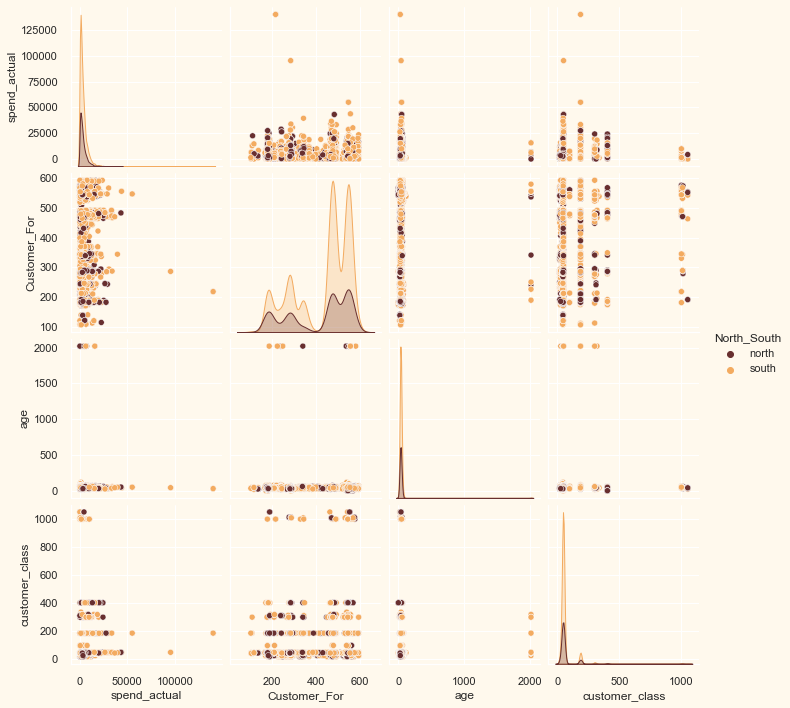

In [12]:
#To plot some selected features based on customers living in the North or South
#Setting up colors prefrences
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])
#Plotting following features
To_Plot = [ "North_South", "spend_actual", "Customer_For","age", "customer_class",]
print("Relative Plot Of Some Selected Features: A Data Subset")
plt.figure()
sns.pairplot(data[To_Plot], hue= "North_South",palette= (["#682F2F","#F3AB60"]))
#Taking hue 
plt.show()

## Insight: There are more high value customers in the south than in the .

### The customers in the north usually spend between 0 to 15000 on all mobile services,are less than 40 years old and have been customers for less than a year (200 days).


#### Clearly, there are a outliers in the customer_class,spend_actual,age features. 
##### will be deleting the outliers in the data. 

In [13]:
#Dropping the outliers by setting a cap on Age and income. 
data = data[(data["age"]<100)]
data = data[(data["customer_class"]<500)]
data = data[(data["spend_actual"]<60000)]
data = data[(data["customer_class"]<500)]

print("The total number of data-points after removing the outliers are:", len(data))

The total number of data-points after removing the outliers are: 23765


Exploring the correlation amongst the features. 
(Excluding the categorical attributes at this point)

<AxesSubplot:>

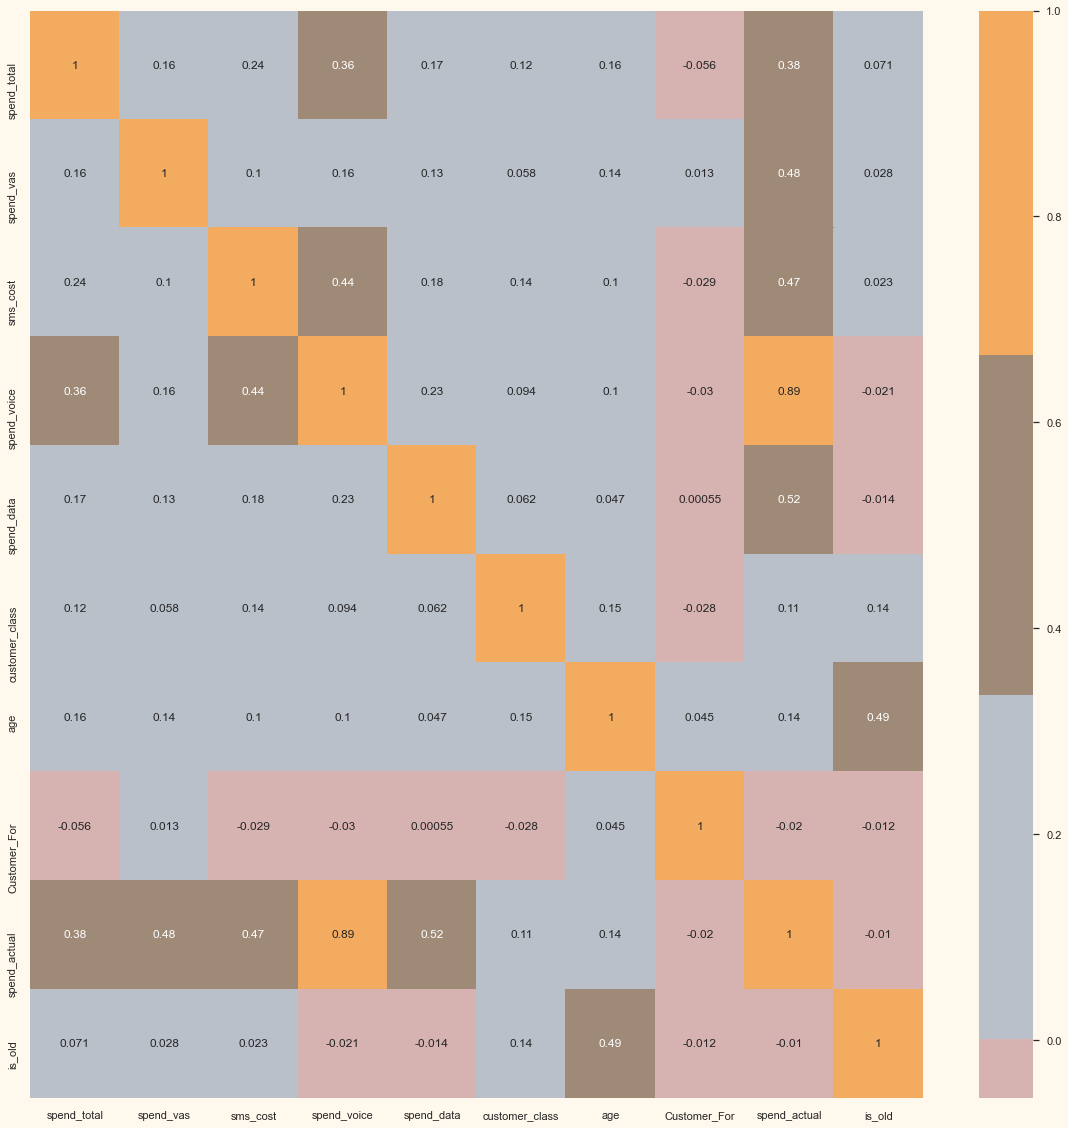

In [14]:
#correlation matrix
corrmat= data.corr()
plt.figure(figsize=(20,20))  
sns.heatmap(corrmat,annot=True, cmap=cmap, center=0)

The data is quite clean and the new features have been included.

<a id="4"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">DATA PREPROCESSING</p>



**The following steps are applied to preprocess the data:**

* Label encoding the categorical features
* Scaling the features using the standard scaler 
* Creating a subset dataframe for dimensionality reduction

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23765 entries, 0 to 27563
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   event_type           23765 non-null  object 
 1   ad_text              23714 non-null  object 
 2   spend_total          23765 non-null  float64
 3   spend_vas            23765 non-null  float64
 4   sms_cost             23765 non-null  float64
 5   spend_voice          23765 non-null  float64
 6   spend_data           23765 non-null  float64
 7   customer_class       23765 non-null  float64
 8   customer_value       23765 non-null  object 
 9   age                  23765 non-null  float64
 10  gender               23616 non-null  object 
 11  has_bank             23765 non-null  object 
 12  location_region      22320 non-null  object 
 13  location_state       22320 non-null  object 
 14  location_lga         22534 non-null  object 
 15  device_manufacturer  23528 non-null 

In [16]:
#Get list of categorical variables
s = (data.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['event_type', 'ad_text', 'customer_value', 'gender', 'has_bank', 'location_region', 'location_state', 'location_lga', 'device_manufacturer', 'device_model', 'device_type', 'os_vendor', 'os_name', 'customer_status', 'North_South']


In [17]:
#Label Encoding the object dtypes.
LE=LabelEncoder()
for i in object_cols:
    data[i]=data[[i]].apply(LE.fit_transform)
    
print("All features are now numerical")

All features are now numerical


In [18]:
#dropping for the three missing values in this field
missing_index = data[data['Customer_For'].isnull()].index.tolist()
data.drop(missing_index,inplace = True)

In [19]:
#Creating a copy of data
ds = data.copy()
# creating a subset of dataframe by dropping the features on deals accepted and promotions
cols_del = ['ad_text','event_type']
ds = ds.drop(cols_del, axis=1)
#Scaling
scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds),columns= ds.columns )
print("All features are now scaled")

All features are now scaled


In [20]:
#Scaled data to be used for reducing the dimensionality
print("Dataframe to be used for further modelling:")
scaled_ds.head()

Dataframe to be used for further modelling:


,spend_total,spend_vas,sms_cost,spend_voice,spend_data,customer_class,customer_value,age,gender,has_bank,...,device_manufacturer,device_model,device_type,os_vendor,os_name,Customer_For,spend_actual,customer_status,is_old,North_South
0,0.238957,-0.344419,-0.402049,-0.728096,-0.536391,-0.200733,1.465732,-0.454786,0.506171,-0.300167,...,0.574718,-1.076622,0.158205,-0.340335,0.840061,0.920944,-0.834877,-0.651792,-0.150018,-1.540438
1,-0.604470,-0.294612,-0.065002,0.000295,-0.010093,-0.264539,-0.443807,1.425213,0.506171,-0.300167,...,1.014641,-1.372751,0.158205,-0.161872,-0.335461,1.222739,-0.099165,0.581320,-0.150018,0.363238
2,-0.235225,-0.082935,0.034129,0.187767,-0.483761,-0.689917,-1.080321,-0.355839,0.506171,-0.300167,...,-1.055585,0.437192,0.158205,-0.161872,-0.335461,0.325295,-0.028270,-0.651792,-0.150018,2.266915
3,2.485542,0.933948,1.322839,0.173654,2.095098,-0.200733,0.829219,1.524160,0.506171,-0.300167,...,1.014641,0.662250,0.158205,-0.161872,-0.335461,0.920944,1.119926,-0.651792,-0.150018,0.363238
4,2.295549,1.207884,0.549613,-0.155552,0.340772,5.137763,0.829219,1.425213,2.851656,-0.300167,...,-1.391997,1.024713,0.158205,-0.161872,-0.671324,0.349121,0.395406,-0.651792,-0.150018,0.363238


<a id="5"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">DIMENSIONALITY REDUCTION</p>

**Steps in this section:**
* Dimensionality reduction with PCA
* Plotting the reduced dataframe

**Dimensionality reduction with PCA**

For this project, I will be reducing the dimensions to 3.

In [21]:
#Initiating PCA to reduce dimentions aka features to 3
pca = PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["col1","col2", "col3"]))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,23762.0,-3.232738e-17,1.781941,-2.833940,-1.166143,-0.438284,0.666717,19.605028
col2,23762.0,1.203575e-17,1.522416,-3.716154,-1.238112,0.682720,0.892811,4.238256
col3,23762.0,-5.920691e-17,1.373102,-5.400739,-0.581965,-0.373149,-0.099363,7.609221


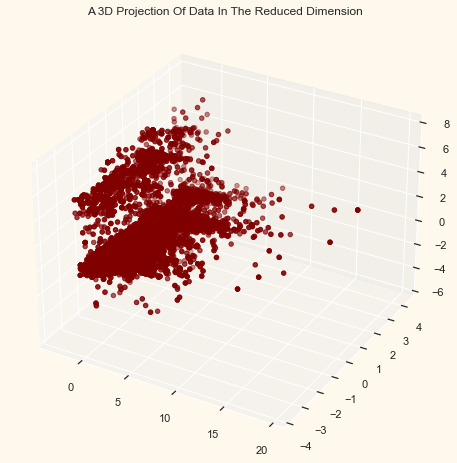

In [22]:
#A 3D Projection Of Data In The Reduced Dimension
x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

<a id="6"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">CLUSTERING</p>

Performing clustering via Agglomerative clustering. Agglomerative clustering is a hierarchical clustering method.  It involves merging examples until the desired number of clusters is achieved.

**Steps involved in the Clustering**
* Elbow Method to determine the number of clusters to be formed
* Clustering via Agglomerative Clustering
* Examining the clusters formed via scatter plot

Elbow Method to determine the number of clusters to be formed:


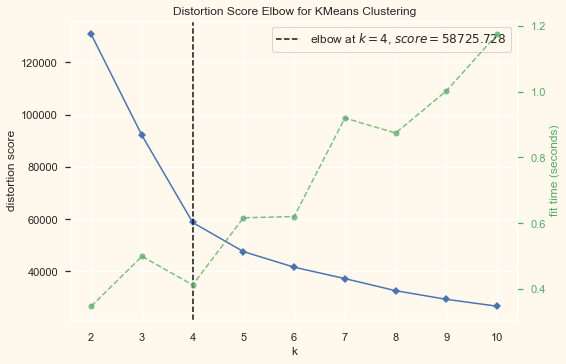

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [23]:
# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_ds)
Elbow_M.show()

The above cell indicates that four will be an optimal number of clusters for this data. 
Next, fitting the Agglomerative Clustering Model to get the final clusters. 

In [ ]:
#Initiating the Agglomerative Clustering model 
AC = AgglomerativeClustering(n_clusters=4)
# fit model and predict clusters
yhat_AC = AC.fit_predict(PCA_ds)
PCA_ds["Clusters"] = yhat_AC
#Adding the Clusters feature to the orignal dataframe.
data["Clusters"]= yhat_AC

To examine the clusters formed let's have a look at the 3-D distribution of the clusters. 

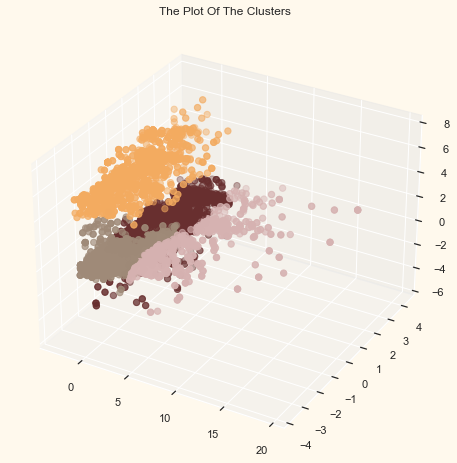

In [24]:
#Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=PCA_ds["Clusters"], marker='o', cmap = cmap )
ax.set_title("The Plot Of The Clusters")
plt.show()

<a id="7"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">EVALUATING MODELS</p>

Since this is an unsupervised clustering. We do not have a tagged feature to evaluate or score our model. The purpose of this section is to study the patterns in the clusters formed and determine the nature of the clusters' patterns. 

For that, we will be having a look at the data in light of clusters via exploratory data analysis and drawing conclusions. 

**Firstly, let us have a look at the group distribution of clustring**

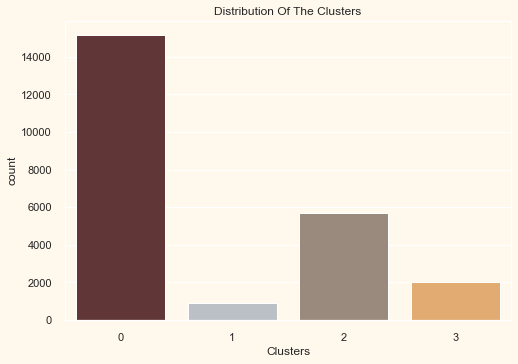

In [25]:
#Plotting countplot of clusters
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=data["Clusters"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

The clusters seem to be heavily weighted towards cluster 0.

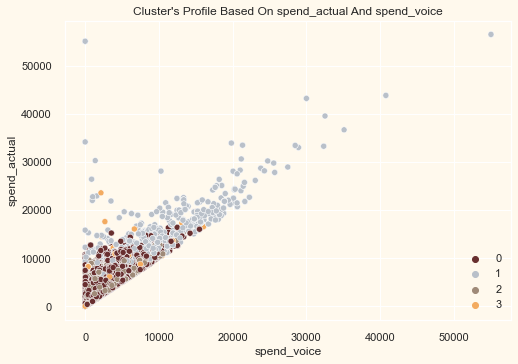

In [40]:
pl = sns.scatterplot(data = data,x=data["spend_voice"], y=data["spend_actual"],hue=data["Clusters"], palette= pal)
pl.set_title("Cluster's Profile Based On spend_actual And spend_voice")
plt.legend()
plt.show()

**Spend_actual vs  spend_voice shows the clusters pattern**
* group 0: low spend_voice & low Spend_actual
* group 1: spend_voice & Spend_actual
* group 2: spend_voice & Spend_actual
* group 3: low spend_voice & high Spend_actual

In [ ]:
#swarm plot takes a while to run
#plt.figure()
#pl=sns.swarmplot(x=data["Clusters"], y=data["spend_actual"], color= "#CBEDDD", alpha=0.5 )
#pl=sns.boxenplot(x=data["Clusters"], y=data["spend_voice"], palette=pal)
#plt.show()


From the above swarm plot commented out , it can be clearly seen that cluster 0 is forms the biggest set of customers that install or click based on ad_campaigns followed by cluster 1, other clustes have similar distributions.
We can explore what each cluster is spending on for the targeted ad campaigns.


In [ ]:
#for more details on the spending style style 
#Places =[" "] 

#for i in Places:
#    plt.figure()
#    sns.jointplot(x=data[i],y = data[" "],hue=data["Clusters"], palette= pal)
#    plt.show()

<a id="8"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">PROFILING-FUTURE WORK</p>

Since clusters have been formed we can consider purchasing habits across gender and age e.t.c. this can identify more granular groups that need attention from the ads marketing team.
 

In [ ]:
#code for profiling
#Personal = [ " "]

#for i in Personal:
#    plt.figure()
#    sns.jointplot(x=data[i], y=data[" "], hue =data["Clusters"], kind="kde", palette=pal)
#    plt.show()


<a id="9"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">CONCLUSION</p>

#### In this project, unsupervised clustering was performed using dimensionality reduction followed by agglomerative clustering 4 clusters were developed and further used in profiling customers in clusters according to their geographical location and telecom services spending.

##  Marketing strategies deduced are:

### 1. Customers in the database that are most likely to interact with adcampaigns are the: based in the south and have a low total spend on telecom services as related to spending on voice services alone.
    
### 2. Customers in the North having less than 40 years of age and less than a total of 15000 actual spend across telecoms services could be targeted if the goal is the increaser the customer base in the North region. 

### This can be used in planning better marketing strategies. 

## Future work

### Evaluating cluster models based on K-Means and Kmodes models.

### further work would include  profiling the customers across telecom services  grouped by age, and customer value comparing the cluster characteristics with similar analysis on  the "general population" database.

## Challenges 
### Codes were run locally so agglomerative models and swarm plots take a while to render.


<a id="10"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">END</p>